# Классификация дефектов кожи

## Дипломная работа Жеманцевой Татьяны. Skillfactory.

## Задача: создание модели классификации, которая по представленной картинке кожного покрова сможет определить варианты с процентным оотношением похожести данного дефекта на известное заболевание.
 
## Данные взяты с kaggle - закрытое соревнование, данные для которого взяты и отсортированы в ISIC (https://www.isic-archive.com).
## В данной работе выполнена классификация с использованием CNN и предобученой нейросети в Tensorflow - Xception.

In [1]:
#!pip install -q tensorflow==2.3
#!pip install keras_efficientnets
#!pip freeze > requirements.txt

# Импортируем библиотеки 

In [2]:
# Импортируем библиотеки

import pandas as pd # импортируем необходимые библиотеки
import numpy as np
import re
import random
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import ExtraTreeRegressor
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 

from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import itertools 

#from catboost import CatBoostRegressor

from tqdm import tqdm
from tqdm.notebook import tqdm

from itertools import combinations
from scipy.stats import ttest_ind


# # keras
import tensorflow as tf
from tensorflow import keras
#import tensorflow.keras.layers as L
#from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
#import albumentations
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#import tensorflow as tf
import tensorflow.keras 
import tensorflow.keras.models #as M
#import tensorflow.keras.layers as L
#import tensorflow.keras.backend #as K
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay as ExpDecay
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from glob import glob
from glob import iglob
#from keras.applications import InceptionV3
#from keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense ,LeakyReLU,UpSampling2D, GlobalAveragePooling2D,Conv2DTranspose, BatchNormalization,GlobalMaxPool2D, Convolution2D

import nltk
from nltk.corpus import stopwords

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
#DATA_PATH = "/content/drive/My Drive/cars2/"
#PATH = "/content/"  # рабочая директория

In [3]:
#from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB4
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.1


In [4]:
print(tf.__version__)

2.4.1


In [5]:
#from tensorflow.keras.applications import InceptionV3#
#keras.applications.EfficientNetB4()

In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpmodel.summary()y        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpmodel.summary()y        : 1.19.5
Tensorflow   : 2.4.1


# Задаем константы

In [8]:
train_path = "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
test_path =  "/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

In [9]:
RANDOM_SEED = 40
IMAGE_SIZE         = (299, 299)
#INPUT_SHAPE        = (224, 224, 3)
IMG_SIZE           = 299 # размер входного изображения для Xception по-умолчанию
IMG_CHANNELS       = 3   # у RGB 3 канала
input_shape        = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
# Keras settings
BATCH_SIZE = 3
VAL_BATCH_SIZE = 3
VAL_SPLIT          = 0.13 # сколько данных выделяем на тест = 15%
EPOCHS = 25
LR = 0.00001

# Предобработка изображений: просмотр, аугментация, создание обучающего и тестового наборов

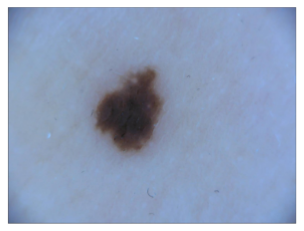

In [79]:
# Посмотрим пример картинки

img = PIL.Image.open(train_path + "nevus/ISIC_0000041.jpg") # load_img(train_path + "nevus/ISIC_0000041.jpg")  "ISIC_0000398.jpg"
plt.imshow(img)
plt.axis("off")
plt.show()


In [80]:
# Преобразуем картинку в массив

x = img_to_array(img)
print(x.shape)

(1129, 1504, 3)


In [10]:
# C помощью glob определяем сколько разных папок-классов с картинками имеется.

className = glob(train_path + '/*' )
numberOfClass = len(className)
print("NumberOfClass: ",numberOfClass)

NumberOfClass:  9


In [11]:
className_t = glob(test_path + '/*' )
numberOfClass_t = len(className_t)
print("NumberOfClass: ",numberOfClass_t)

NumberOfClass:  9


In [14]:
className

['/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis',
 '/kaggle/input/skin-cancer9-classesisic/skin cancer isic the international skin imaging collaboration/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma',
 '/kaggle/input/skin-cancer9-classesisic/

## Аугментация с помощью ImageDataGenerator (выполняется либо этот раздел аугментации, либо следующий )

In [10]:
# Аугментация обучающего датасета
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 60,
    brightness_range = [0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    fill_mode='reflect')  #  fill_mode='nearest'

       
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=VAL_SPLIT)

In [11]:
# Завернем наши данные в генератор.

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation') # set as validation data


Found 1952 images belonging to 9 classes.
Found 287 images belonging to 9 classes.


In [12]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)


Found 118 images belonging to 9 classes.


## Аугментация с помощью albumentations (выполняется либо этот раздел аугментации, либо предыдущий)

In [16]:
!pip install albumentations

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [17]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-rp4s97g3
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-rp4s97g3
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=51bacdc25934b2576c95a974af65de6a0ff9c333fba1a1091e220d92bed6ed8d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ir_9o7fu/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [18]:
#Аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.

import albumentations
import cv2
from ImageDataAugmentor.image_data_augmentor import *
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [19]:
#  этот вариант

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=90),
    albumentations.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
    albumentations.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
   # albumentations.HueSaturationValue(p=0.5),
    albumentations.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    albumentations.RandomContrast(limit=0.1, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [14]:
# Либо этот вариант. 


AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5), #0.5
    albumentations.Rotate(limit=20, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
        albumentations.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
   # albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

      
test_datagen = ImageDataAugmentor(rescale=1./255)

val_datagen = ImageDataAugmentor(rescale=1. / 255, validation_split=VAL_SPLIT)

In [20]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    train_path,      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data



/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 1952 images belonging to 9 classes.
Found 287 images belonging to 9 classes.


In [13]:
test_val_generator = test_datagen.flow_from_directory(
    directory=test_path,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE)

Found 118 images belonging to 9 classes.


In [37]:
# Переведем картинки в массивы  -- не надо

train_pairs = [next(train_generator) for i in range(len(train_generator))]
val_pairs = [next(test_generator) for i in range(len(test_generator))]
train_images = np.concatenate([x[0] for x in train_pairs], axis = 0)
train_labels = np.concatenate([x[1] for x in train_pairs], axis = 0)
val_images = np.concatenate([x[0] for x in val_pairs], axis = 0)
val_labels = np.concatenate([x[1] for x in val_pairs], axis = 0)

Пример картинок из train_generator


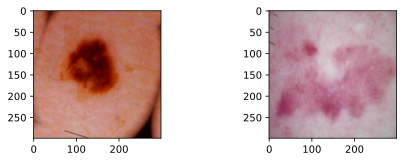

In [18]:
# Прсмотрим несколько картинок после применения аугментации.

from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,2):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
   # plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

In [22]:
imgs, labels = next(train_generator)
print(imgs.shape, labels.shape)

(3, 299, 299, 3) (3, 9)


In [23]:
imgs, labels = next(test_generator)
print(imgs.shape, labels.shape)
print(len(test_generator))

(3, 299, 299, 3) (3, 9)
96


# Посмотрим распределение данных по классам.

In [34]:

def classes_count (path):
    # определяет содержимое папок классов
    
    classes = []
    for filename in iglob(os.path.join(path, "**","*.jpg")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])
    cnt = Counter(classes)
    return cnt

def percentage_value(pct, allvals):
    # вычисляет процентное значение размера класса
    
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    # строит круговую диаграмму
    
    classes_cnt = classes_count(path)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140)

    plt.title(title + ' размера ' + str(sum(classes_cnt.values())))    
    plt.show()

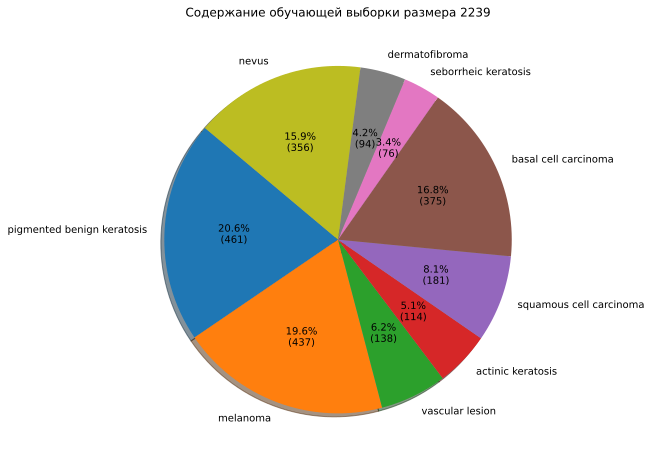

In [25]:
plot_dataset_description(os.path.join(train_path), "Содержание обучающей выборки")

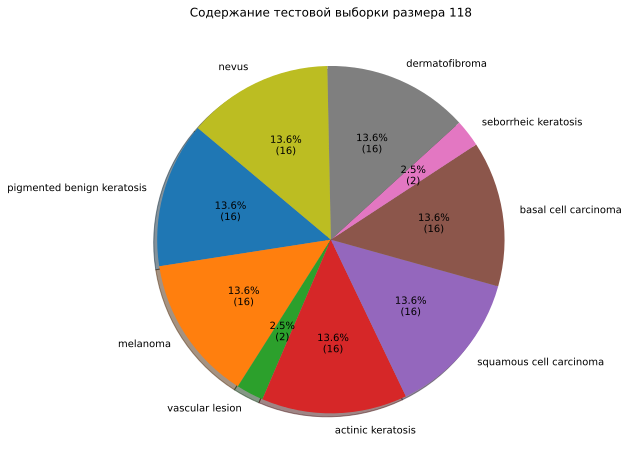

In [26]:
plot_dataset_description(os.path.join(test_path), "Содержание тестовой выборки")

In [27]:
def plot_dataset_description_bar(path, title):
    # строит диаграмму столбиками
 
    classes_val = classes_count(path)
    values = list(classes_val.values())
    labels = list(classes_val.keys())
    plt.figure(figsize=(10, 5))
    plt.bar(values, (values), width=10)
    plt.ylabel('Количество картинок', fontsize=10)
    plt.xticks(values, labels, fontsize=8, rotation=90)
    plt.title(title)

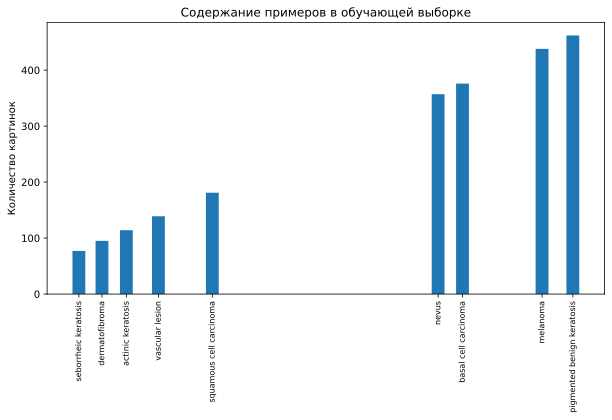

In [28]:
plot_dataset_description_bar(os.path.join(train_path), 'Содержание примеров в обучающей выборке')

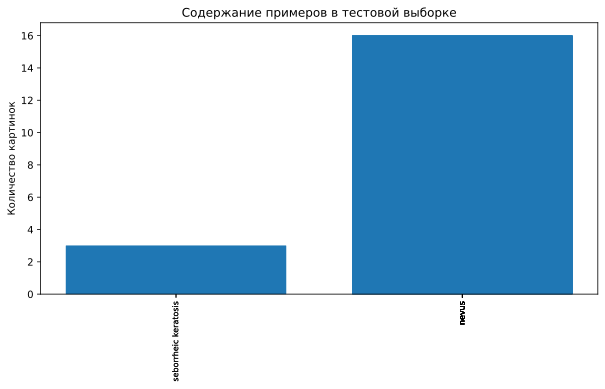

In [29]:
plot_dataset_description_bar(os.path.join(test_path), 'Содержание примеров в тестовой выборке')

# Анализ данных показывает, что наша выборка несбалансирована, поскольку самый многочисленный класс в 5 раз превышает самый маленький.
# В этом случае нам подошли бы метрики precision, recall, F1-score, учитывающие веса классов, но они используются в бинарной классификации. В работе использовалась метрика accuracy.
# Для учета дисбаланса классов для каждого класса добавлены веса в параметр class_weight при обучении,что позволило повысить точность модели.

 
# В задаче для оценки эффективности  модели в процессе обучения я использовала
# 1. accurancy - с и без использования class_weight 
# 2. Для многоклассовой выборки с несбалансированными классами на просторах интернета рекомендуют использовать метрику macro F1. Создала свои функции для подсчета loss и macro F1 - решение давало достаточно низкую степень обучаемости, от идеи отказалась. на 45 эпохе результаты: loss: 1.0659 - f1: 0.2935 - val_loss: 1.8877 - val_f1: 0.1625
# Также попробовала оптимизацию по созданной функции потерь F1_loss - на 40й эпохе результат F1 = 0.23.

# 3. Оптимизировала модель по loss - категориальная кросс энтропия. 

 



# Построение и обучение модели.

In [ ]:
#model = keras.models.load_model('/kaggle/input/inputmod/best_model_step1.hdf5')

## Вынесем функции для раздела построения и обучения модели.

In [41]:
def info_layers():
    # вывод информации по слоям модели в процессе тюнинга
    
    print("Number of layers in the model:", len(model.layers))
    print("Number of trainable_variables layers in the model:", len(model.trainable_variables))
    print("Number of layers in the base model: ", len(base_model.layers))
    print("Number of variables layers in the base model: ", len(base_model.trainable_variables))
    print("Layers in the model:")
    for layer in model.layers:
        print(layer, layer.trainable)

def graph(history):
    # построние графиков изменения метрики и функции потерь в процессе обучения по эпохам
    
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], 'b*-', label="training acc")
    plt.plot(history.history['val_accuracy'], 'r*-', label="validation acc")
    plt.grid()
    plt.title("train_acc vs val_acc")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], 'b*-', label="training loss")
    plt.plot(history.history['val_loss'], 'r*-', label="validation loss")
    plt.grid()
    plt.title("Training and validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    
    


In [ ]:
# Создадим собственную метрику f1 и функцию потерь - f1_loss

from keras import backend as K

def f1(y_true, y_pred):
    # метрика macro F1
    
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    # функция потерь
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [42]:
# CallBack для сохранения модели, ее весов и лучшей модели, изменения LR в случае отсутствия прогресса обучения, и остановка обучения

weightpath = "best_model.hdf5"
#checkpoint = ModelCheckpoint(weightpath , monitor = 'val_f1' , mode = 'max', verbose = 1,save_best_only=True)
checkpoint = ModelCheckpoint(weightpath , monitor = 'val_accuracy' , mode = 'max', verbose = 1,save_best_only=True) #save_weights_only=True
reducer = ReduceLROnPlateau(monitor='loss', patience= 3,factor=0.2, min_lr=0.00000001,  verbose = 1, cooldown=2, mode='min',min_delta=0.0000001) #min_delta=0.000000001
early_stop= EarlyStopping(monitor='loss',patience= 10, mode='min')  #min_delta=0.000000001


In [43]:
callbacks_list = [checkpoint, reducer, early_stop] 

In [44]:
# Выведем классы для удобства проставления весов

classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


In [45]:
# Установим вес "2"и "3" для классов, размер которых в 2-3 раза меньше самых больших классов, сделав эти классы в 2-3 раза важнее

class_weight = {0: 2.6, 1: 1., 2: 2.8, 3: 1.2, 4: 0.9, 5: 0.9, 6: 3, 7: 2.2, 8: 2.}

## Шаг1  Сформируем модель

In [ ]:
# В процессе обучения проводились опыты с разными моделями, в качестве base_model необходимо выбрать  Xception, 
# как показавшую лучшие результаты

#base_model2 = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

In [46]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [47]:
# Установим все слои base_model в неактивное состояние

base_model.trainable = False

In [ ]:
# CNN модель (вариант 1)

model=Sequential()
##model.add(base_model)

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
print('ок')
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
#model.add(L.Dense(512,activation='relu'))
#model.add(L.BatchNormalization())
model.add(Dense(numberOfClass, activation='softmax'))

In [32]:
# CNN модель с добавлением Xception, которая показала наилучший результат 

model = Sequential()
 
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(numberOfClass, activation='softmax'))



In [49]:
# Посмотрим информацию о количестве слоев модели и модели Imagenet

info_layers()

Number of layers in the model: 4
Number of trainable_variables layers in the model: 2
Number of layers in the base model:  132
Number of variables layers in the base model:  0
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f2598246550> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2593fc0e50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2590129cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2590133090> True


In [50]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 112

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [51]:
info_layers()

Number of layers in the model: 4
Number of trainable_variables layers in the model: 25
Number of layers in the base model:  132
Number of variables layers in the base model:  23
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f2598246550> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2593fc0e50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2590129cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2590133090> True


In [31]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [33]:
# Посмотрим на схему модели.

#from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [189]:
# Компилируем модель

LR=0.0009
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision()])
#model.compile(optimizer=optimizers.Adam(LR),loss=f1_loss, metrics=f1)
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=f1)
#model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])  #  keras.losses.CategoricalCrossentropy

In [190]:
%%time
history = model.fit(
        train_generator,
        #train_images, train_labels,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 8, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/8
651/651 [==============================] - 59s 87ms/step - loss: 0.2683 - accuracy: 0.9096 - val_loss: 2.1466 - val_accuracy: 0.6028

Epoch 00001: val_accuracy improved from -inf to 0.60279, saving model to best_model.hdf5
Epoch 2/8
651/651 [==============================] - 53s 82ms/step - loss: 0.3062 - accuracy: 0.9059 - val_loss: 1.8611 - val_accuracy: 0.6341

Epoch 00002: val_accuracy improved from 0.60279 to 0.63415, saving model to best_model.hdf5
Epoch 3/8
651/651 [==============================] - 53s 81ms/step - loss: 0.3144 - accuracy: 0.8928 - val_loss: 1.9662 - val_accuracy: 0.5923

Epoch 00003: val_accuracy did not improve from 0.63415
Epoch 4/8
651/651 [==============================] - 53s 81ms/step - loss: 0.3288 - accuracy: 0.8943 - val_loss: 1.5156 - val_accuracy: 0.6307

Epoch 00004: val_accuracy did not improve from 0.63415
Epoch 5/8
651/651 [==============================] - 53s 81ms/step - loss: 0.2654 - accuracy: 0.9085 - val_loss: 1.7157 - val_accurac

In [191]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_10v12.hdf5')
model.load_weights('best_model.hdf5')

In [17]:
#model = keras.models.load_model('/kaggle/input/inputqw/model_last_017_83.hdf5')

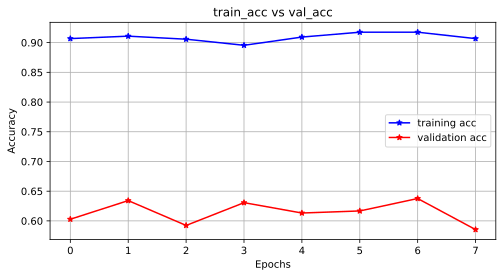

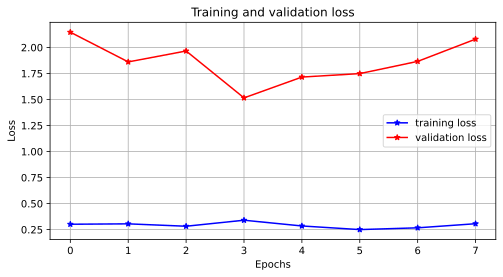

In [192]:
graph(history)

# Шаг2 Изменим количество неактивных слоев в сети imagenet и дообучим модель

In [53]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [51]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 8
Number of trainable_variables layers in the model: 81
Number of layers in the base model:  132
Number of variables layers in the base model:  75
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f0e0438f490> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0e074e2c10> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f0d6150ac10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d6150abd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f0d61524250> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d61504e90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f0d61527590> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d6152f350> True


In [87]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [54]:
# Компилируем модель

LR=0.0007
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 35, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/35
524/524 [==============================] - 59s 106ms/step - loss: 3.3296 - accuracy: 0.3678 - val_loss: 1.5517 - val_accuracy: 0.4746

Epoch 00001: val_accuracy did not improve from 0.55892
Epoch 2/35
524/524 [==============================] - 53s 101ms/step - loss: 2.0764 - accuracy: 0.5176 - val_loss: 1.3846 - val_accuracy: 0.5644

Epoch 00002: val_accuracy improved from 0.55892 to 0.56437, saving model to best_model.hdf5
Epoch 3/35
524/524 [==============================] - 53s 101ms/step - loss: 1.5835 - accuracy: 0.6405 - val_loss: 1.4624 - val_accuracy: 0.5284

Epoch 00003: val_accuracy did not improve from 0.56437
Epoch 4/35
524/524 [==============================] - 54s 103ms/step - loss: 1.3455 - accuracy: 0.6985 - val_loss: 2.8034 - val_accuracy: 0.3937

Epoch 00004: val_accuracy did not improve from 0.56437
Epoch 5/35
524/524 [==============================] - 54s 104ms/step - loss: 1.2188 - accuracy: 0.7334 - val_loss: 2.0284 - val_accuracy: 0.4716

Epoch 00005: 

In [56]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_9v22.hdf5')
model.load_weights('best_model.hdf5')

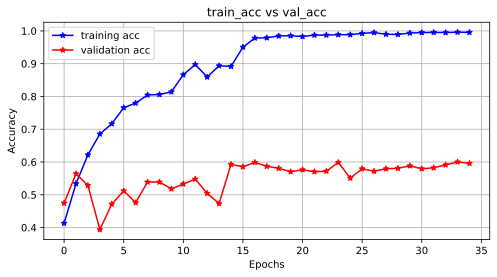

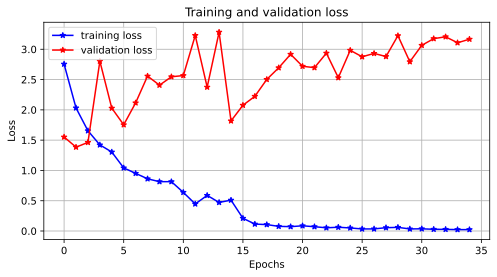

In [57]:
graph(history)

In [23]:
# Шаг3
#model = keras.models.load_model('/kaggle/input/inputqw/model_last_017_83.hdf5')

In [ ]:
# Шаг3 Снова изменим количество неактивных слоев в сети imagenet и дообучим модель

In [69]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


In [67]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 8
Number of trainable_variables layers in the model: 150
Number of layers in the base model:  132
Number of variables layers in the base model:  144
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7f0e0438f490> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0e074e2c10> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7f0d6150ac10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d6150abd0> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f0d61524250> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d61504e90> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f0d61527590> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0d6152f350> True


In [68]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [70]:
# Компилируем модель

LR=0.000078
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator), #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 25, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=len(test_generator), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

Epoch 1/25
599/599 [==============================] - 82s 130ms/step - loss: 3.2989 - accuracy: 0.5909 - val_loss: 2.1517 - val_accuracy: 0.5180

Epoch 00001: val_accuracy did not improve from 0.60030
Epoch 2/25
599/599 [==============================] - 77s 128ms/step - loss: 1.3626 - accuracy: 0.6708 - val_loss: 1.6572 - val_accuracy: 0.6036

Epoch 00002: val_accuracy improved from 0.60030 to 0.60360, saving model to best_model.hdf5
Epoch 3/25
599/599 [==============================] - 78s 130ms/step - loss: 0.7940 - accuracy: 0.7969 - val_loss: 1.7886 - val_accuracy: 0.5405

Epoch 00003: val_accuracy did not improve from 0.60360
Epoch 4/25
599/599 [==============================] - 75s 125ms/step - loss: 0.6165 - accuracy: 0.8355 - val_loss: 1.8470 - val_accuracy: 0.6194

Epoch 00004: val_accuracy improved from 0.60360 to 0.61937, saving model to best_model.hdf5
Epoch 5/25
599/599 [==============================] - 78s 131ms/step - loss: 0.3431 - accuracy: 0.9106 - val_loss: 1.9175 

In [74]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_9v23.hdf5')
model.load_weights('best_model.hdf5')

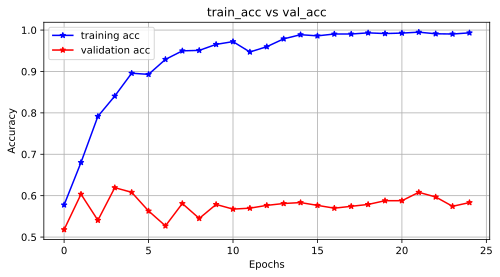

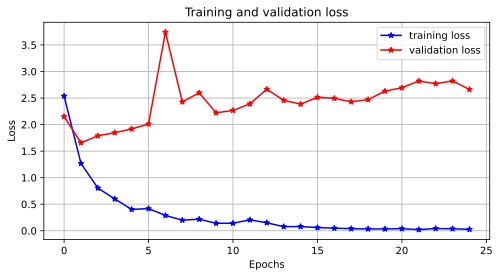

In [75]:
graph(history)

In [ ]:
# Шаг4

In [32]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 41

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False



In [34]:
# Посмотрим информацию о количестве слоев модели 

info_layers()

Number of layers in the model: 7
Number of trainable_variables layers in the model: 69
Number of layers in the base model:  132
Number of variables layers in the base model:  97
Layers in the model:
<tensorflow.python.keras.engine.functional.Functional object at 0x7faa902afc10> True
<tensorflow.python.keras.layers.core.Flatten object at 0x7fa9e01e5cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa9e0198750> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7fa9e018f210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fa9e01fca50> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7faa902a4bd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7faa90151310> True


In [35]:
# Посмотрим структуру модели

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten (Flatten)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1

In [36]:
# Компилируем модель

LR=0.0008
model.compile(optimizer=optimizers.Adam(LR),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples, #train_generator.samples, # train_generator.samples # len(train_generator)
        epochs= 25, #EPOCHS,
        class_weight=class_weight,
        validation_data=test_generator,
        validation_steps=(test_generator.samples), #test_generator.samples,  # test_generator.samples
        callbacks = callbacks_list)

In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)

model.save('model_last_v4.hdf5')
model.load_weights('best_model.hdf5')

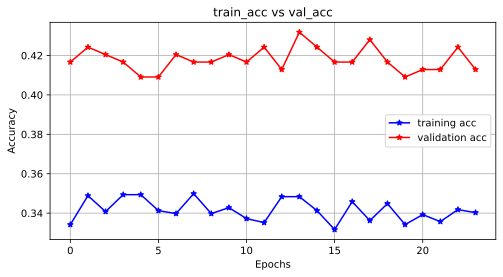

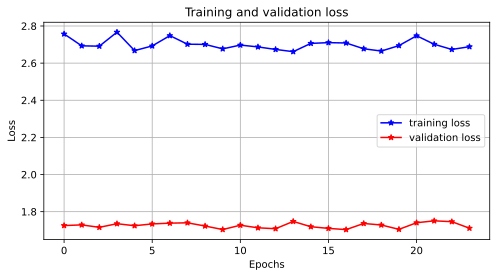

In [38]:
graph(history)

# Результаты

In [ ]:
# Считаем финальную точность модели по Accuracy и Loss

score_loss, score_acc = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("F1: %.2f%%" % (score_acc*100))
print("Loss: %.2f%%" % (score_loss))

## Confugn matrix по тестовым данным

In [18]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    # функция рисования confusion_matrix

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [24]:
%%time
Y_pred1 = model.predict(test_val_generator,verbose=1)  # test_val_generator
y_pred_val = np.argmax(Y_pred1, axis=1)
y_pred_val

40/40 [==============================] - 10s 247ms/step
CPU times: user 10.6 s, sys: 601 ms, total: 11.2 s
Wall time: 10.5 s


array([7, 3, 0, 0, 7, 5, 0, 0, 0, 0, 0, 0, 7, 5, 5, 5, 1, 1, 7, 1, 5, 1,
       0, 5, 1, 8, 1, 1, 1, 1, 1, 1, 5, 5, 5, 7, 5, 2, 5, 2, 2, 2, 8, 7,
       5, 1, 2, 7, 3, 8, 3, 3, 3, 3, 3, 1, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 3, 3, 5, 3, 5, 4, 3, 4, 3, 3, 7, 7, 1, 5, 3, 5, 5, 5,
       5, 5, 3, 7, 7, 5, 5, 1, 3, 3, 3, 5, 3, 7, 7, 1, 7, 7, 7, 7, 7, 1,
       1, 7, 1, 7, 7, 8, 8, 8])

In [25]:
cnf_matrix_val = confusion_matrix(test_val_generator.classes, y_pred_val)
classes = {v: k for k, v in test_val_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


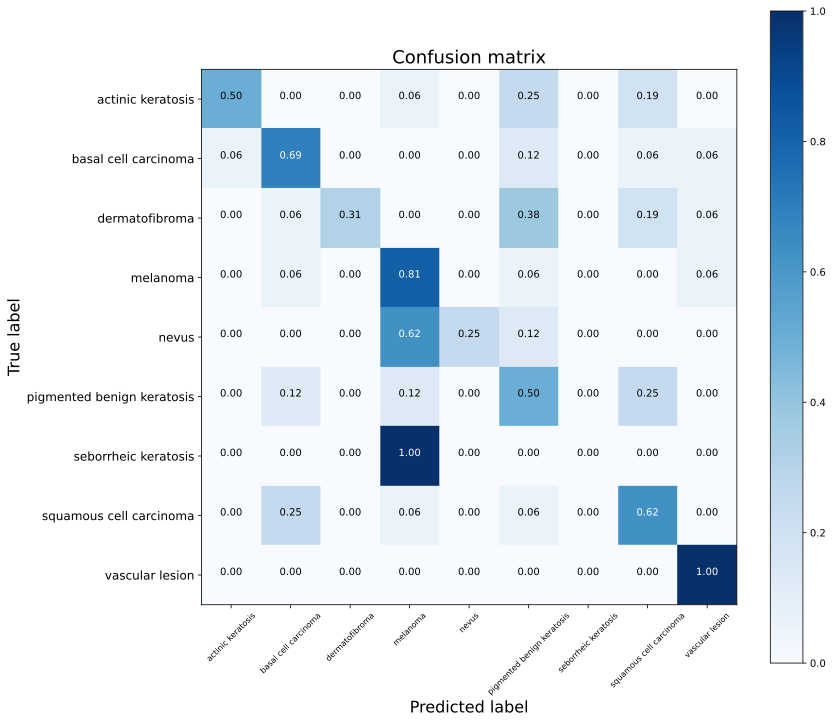

In [26]:
plot_confusion_matrix(cnf_matrix_val, list(classes.values()))

In [27]:
# классификация ответов

print(classification_report(test_val_generator.classes, y_pred_val, target_names=list(classes.values())))

                            precision    recall  f1-score   support

         actinic keratosis       0.89      0.50      0.64        16
      basal cell carcinoma       0.58      0.69      0.63        16
            dermatofibroma       1.00      0.31      0.48        16
                  melanoma       0.43      0.81      0.57        16
                     nevus       1.00      0.25      0.40        16
pigmented benign keratosis       0.33      0.50      0.40        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.48      0.62      0.54        16
           vascular lesion       0.50      1.00      0.67         3

                  accuracy                           0.53       118
                 macro avg       0.58      0.52      0.48       118
              weighted avg       0.65      0.53      0.51       118



# По матрице и по значением метрик в общем результаты неплохие
# accurancy получилась 0.53, макро F1 = 0.48 из 118 примеров
# По классам F1 в среднем 50-60%, один класс seborrheic keratosis модель не смогла предсказать ни разу.

# Tестовая демонстрация.

In [28]:
def load_image(filename):
    # загружает картинку
    
    img = cv2.imread(os.path.join(train_path, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    return img

def predict(imag):
   # x = image.img_to_array(image)
    # возвращает первые три максимальных значений из предсказанных для каждого класса
    probabilities = model.predict(np.asarray([imag]))[0]
#    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = (-probabilities).argsort()[:3]  # np.argmax(probabilities)
    return class_idx, probabilities[class_idx]

def turn(img):
    # функция поворота изображения на 90 градусов
    
    h,w,c = img.shape
    empty_img = img
    for i in range(h):
        for j in range(w):
            empty_img[i,j] = img[h-j-1,w-i-1]
            empty_img = empty_img[0:h,0:w]
    return empty_img

In [29]:
def get_image_augm(img_path, datagen):
    #  функция реализует несколько преобразованных изображений
    
    img = image.load_img(img_path, target_size=(150,140))
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape) # изменение формы на (1,150,150,3)
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    for i, batch in enumerate(datagen.flow(x, batch_size=1)):
        axes[i].imshow(image.array_to_img(batch[0]))
        axes[i].axis('off')
        if i == 1:
            break
            
datagen0 = ImageDataGenerator(   # поворот
    rescale=1./255,
)

datagen1 = ImageDataGenerator(   # поворот
    rescale=1./255,
    rotation_range=155,
)
datagen2 = ImageDataGenerator(    # смещение по ширине
    rescale=1./255,
    width_shift_range=0.5,
)

datagen3 = ImageDataGenerator(   # изменение яркости и канала изображения
    rescale=1./255,
    brightness_range=(.1, .5),
    channel_shift_range=180
)

In [30]:

classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3: 'melanoma', 4: 'nevus', 5: 'pigmented benign keratosis', 6: 'seborrheic keratosis', 7: 'squamous cell carcinoma', 8: 'vascular lesion'}


Источник: class: basal cell carcinoma, file: basal cell carcinoma/ISIC_0025362.jpg
[(array([1, 5, 7]), array([0.75503844, 0.20928323, 0.01427222], dtype=float32)), (array([1, 5, 7]), array([9.8133367e-01, 1.8500105e-02, 1.3821942e-04], dtype=float32)), (array([1, 5, 7]), array([9.8133367e-01, 1.8500105e-02, 1.3821942e-04], dtype=float32))]
0 0 0
Предсказано: класс: basal cell carcinoma, с вероятностью: 0.755038
Предсказано: класс: pigmented benign keratosis, с вероятностью: 0.209283
Предсказано: класс: squamous cell carcinoma, с вероятностью: 0.014272


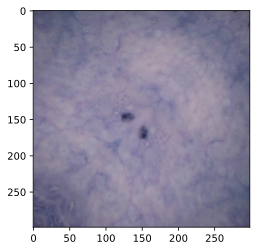

<Figure size 432x288 with 0 Axes>

Источник: class: squamous cell carcinoma, file: squamous cell carcinoma/ISIC_0025069.jpg
[(array([7, 5, 0]), array([0.280175  , 0.27821967, 0.20787184], dtype=float32)), (array([3, 5, 8]), array([0.23692758, 0.21455584, 0.17561251], dtype=float32)), (array([3, 5, 8]), array([0.23692758, 0.21455584, 0.17561251], dtype=float32))]
1 0 1
Предсказано: класс: melanoma, с вероятностью: 0.236928
Предсказано: класс: pigmented benign keratosis, с вероятностью: 0.278220
Предсказано: класс: vascular lesion, с вероятностью: 0.175613


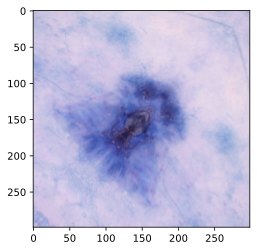

Источник: class: pigmented benign keratosis, file: pigmented benign keratosis/ISIC_0024909.jpg
[(array([3, 4, 5]), array([0.44435433, 0.30566293, 0.11693487], dtype=float32)), (array([3, 5, 4]), array([0.27459502, 0.25079328, 0.20234378], dtype=float32)), (array([3, 5, 4]), array([0.27459502, 0.25079328, 0.20234378], dtype=float32))]
0 1 1
Предсказано: класс: melanoma, с вероятностью: 0.444354
Предсказано: класс: pigmented benign keratosis, с вероятностью: 0.250793
Предсказано: класс: nevus, с вероятностью: 0.202344


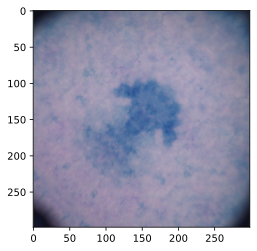

<Figure size 432x288 with 0 Axes>

In [36]:
# Выберем три примера из тестового набора данных и сделаем для них предсказание

for idx, filename in enumerate(random.sample(test_generator.filenames, 3)):    # test_val_generator
    print("Источник: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    path_f = (os.path.join(train_path, filename)) #train_path + filename

    img = load_image(filename)
   
    key0=[]
    key1=[]
    key2=[]
    real_pred=[]
    values = []
    real_class =[]
    prediction = []
    
    # реализация TTA изображения: используем оригинальное изображение и повернутое два раза на 90 градусов
    
    preds =  predict(img)
    prediction.append(preds)

    turn(img)
    preds =  predict(img)
    prediction.append(preds)
    
    turn(img)
    preds =  predict(img)
    prediction.append(preds)
    print(prediction)
    
    for key,value in prediction:      # выделим отдельным списком предсказания классов по максимальной похожести
        key0.append(key[0])
        key1.append(key[1])
        key2.append(key[2])
        values.append(value)   

    n1=key0.index(Counter(key0).most_common(1)[0][0])     # определим координаты наиболее часто встречающегося предсказания
    n2=key1.index(Counter(key1).most_common(1)[0][0])
    n3=key2.index(Counter(key2).most_common(1)[0][0])
#    print( n1,n2,n3)

    real_class =[key0[n1], key1[n2], key2[n3]]              # выберем наиболее частое предсказание для каждого класса
    real_pred= [values[n1][0], values[n2][1], values[n3][2]]
        
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key0[n1]], values[n1][0]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key1[n2]], values[n2][1]))
    print("Предсказано: класс: %s, с вероятностью: %f" % (classes[key2[n3]], values[n3][2]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

# Выводы:
#     На несбалансированной выборке с небольшим набором данных и 9 классами удалось добиться точности ~ 60% за счет следующих шагов:
#         1. выбор подходящей к задаче архитектуры сети c Fine-tuning
#         2. задание весов для классов
#         3. уменьшение batch_size
#         4. подбор LR
#         5. использование аугментации ablumentation
        